<p>This is the first in a collection of tutorials about NEURON's reaction-diffusion module. You may also be interested in these topics:
<ul>
    <li><a href="https://neuron.yale.edu/neuron/docs/reaction-diffusion-varying-initial-concentrations-and-parameters">varying initial concentrations and parameters</a></li>
    <li>non-uniform initial conditions</li><li><a href="/neuron/docs/reaction-diffusion-calcium-wave">calcium wave</a></li><li>location-dependent parameters</li><li>limiting a reaction to part of a region</li><li>radial diffusion</li><li><a href="https://neuron.yale.edu/neuron/docs/reaction-diffusion-thresholds">thresholding reactions</a></li><li>3D intracellular</li><li><a href="https://neuron.yale.edu/neuron/docs/extracellular-diffusion">extracellular diffusion</a></li></ul>
See also:
<ul>
    <li><a href="/neuron/docs/reaction-diffusion-exercises">Reaction-Diffusion exercises from the 2018 NEURON course</a>
</ul>

<h2>Overview</h2>
<p>Proteins, ions, etc... in a cell perform signalling functions by moving, reacting with other molecules, or both. In some cases, this movement is by active transport processes, which we do not consider here. If all movement is due to diffusion (wherein a molecule moves randomly), then such systems are known as reaction-diffusion systems.</p>
<p>
    These problems are characterized by the answers to three questions: (1) <a href="#where">Where</a> do the dynamics occur, (2) <a href="#who">Who</a> are the actors, and (3) <a href="#how">How</a> do they interact?</p>

<h2>Math</h2>
<p>Reaction-diffusion equations are equations or systems of equations of the form<br/><br/>
\[\frac{\partial u}{\partial t} = \nabla \cdot (d \nabla u) + f(u, t)\]
    <br/>
where \(u\) is the concentration of some state variable. If the diffusion coefficient \(D\) is constant, \(\nabla \cdot (d \nabla u) = d \nabla^2 u\) where \(\nabla^2\) is the Laplacian operator. In one-dimensional Cartesian space, \(\nabla^2 u = u_{xx}\), while in three-dimensional Cartesian space \(\nabla^2 u = u_{xx} + u_{yy} + u_{zz}\). This form follows from <a href="http://en.wikipedia.org/wiki/Fick's_laws_of_diffusion">Fick's law of diffusion</a> and the <a href="http://en.wikipedia.org/wiki/Divergence_theorem">Divergence theorem</a> and assumes that the diffusion constant \(d\) is uniform throughout the spatial domain.</p>

<h2>Specification</h2><p>To describe a reaction-diffusion problem in NEURON, begin by loading the <code>rxd</code> library:</p>

In [1]:
from neuron import rxd

Then answer the three questions: where, who, and how.

<h3>Where</h3>
<p>We begin by identifying the domain; i.e. where do the dynamics occur? For many electrophysiology simulations, the only relevant domains are the plasma membrane or the volumes immediately adjacent to it on either side, since these are the regions responsible for generating the action potential. Cell biology models, by contrast, have dynamics spanning a more varied set of locations. In addition to the previous three regions, the endoplasmic reticulum (ER), mitochondria, and nuclear envelop often play key roles.</p>
<p>
    The <a href="https://neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/rxd.html#neuron.rxd.Region"><code>rxd.Region</code></a> class is used to describe the domain:</p>

In [ ]:
r = rxd.Region(sections, nrn_region=None, geometry=None)

<p>
    In its simplest usage, <code>rxd.Region</code> simply takes a Python iterable (e.g. a <code>list</code> or a <a href="https://neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/topology/seclist.html"><code>h.SectionList</code></a>) of <code>h.Section</code> objects. In this case, the domain is the interior of the sections, but the concentrations for any species created on such a domain will only be available through the rxd.Species object and not through HOC or NMODL.</p>

<b>Example:</b> Region on all sections:

In [ ]:
r = rxd.Region(h.allsec())

<b>Example:</b> Region on just a few sections:

In [ ]:
r = rxd.Region([soma, apical1, apical2])

<p>If the region you are describing coincides with the domain on the immediate interior of the membrane, set <code>nrn_region='i'</code>, e.g.</p>

In [ ]:
r = rxd.Region(h.allsec(), nrn_region='i')

Concentration in these regions increases when a molecule of the species of interest crosses from outside the membrane to the inside via an NMODL or kschan mechanism. If a species on such a region is named ca, then its concentrations can be read and set via the NEURON and NMODL range variable <code>cai</code>.

Also: for the region just outside the membrane (the Frankenhaeuser-Hodgkin space) use <code>nrn_region='o'</code>. For full 3D extracellular diffusion, define the region with rxd.Extracellular; for more on extracellular diffusion in NEURON, see <a href="https://doi.org/10.3389/fninf.2018.00041">Newton et al., 2018</a> or the extracellular diffusion tutorial.

Many alternative geometries are available, including: <code>rxd.membrane</code>, <code>rxd.inside</code> (this is the default), <code>rxd.Shell</code> (used in the radial diffusion example; coming soon), <code>rxd.FractionalVolume</code> (used in the <a href="/neuron/docs/reaction-diffusion-calcium-wave">calcium wave example</a>), <code>rxd.FixedCrossSection</code>, and <code>rxd.FixedPerimeter</code>.

<h3>Who</h3>

Who are the actors? Often they are chemical species (proteins, ions), sometimes they are State variables (such as a gating variable), and other times parameters that vary throughout the domain are key actors. All three of these can be described using the <a href="/neuron/static/py_doc/modelspec/programmatic/rxd.html#neuron.rxd.Species"><code>rxd.Species</code></a> class:

In [ ]:
s = rxd.Species(regions=None, d=0, name=None, charge=0, initial=None, atolscale=1)

although we also provide <code>rxd.State</code> and <code>rxd.Parameter</code> for the second and third case, respectively. For now these are exact synonyms of <code>rxd.Species</code> that exist for promoting the clarity of the model code, but this will likely change in the future (so that States can only be changed over time via <code>rxd.Rate</code> objects and that <code>rxd.Parameter</code> objects will no longer occupy space in the integration matrix.)

<b>Note:</b> charge must match the charges specified in NMODL files for the same ion, if any.


The <code>regions</code> parameter is mandatory and is either a single <code>rxd.Region</code> or an iterable of them, and specifies what region(s) contain the species.

Set <code>d=</code> to the diffusion coefficient for your species, if any.

Specify an option for the <code>name=</code> keyword argument to allow these state variables to map to the NEURON/NMODL range variables if the region's <code>nrn_region</code> is <code>'i'</code> or <code>'o'</code>.

Specify initial conditions via the <code>initial=</code> keyword argument. Set that to either a constant or a function that takes a node (defined below, and see also this example).

<b>Example:</b> to have concentrations set to 47 at <code>h.finitialize(init_v)</code>:

In [ ]:
s = rxd.Species(region, initial=47)

<b>Note:</b> For consistency <a href="/neuron/static/docs/units/unitchart.html">with the rest of NEURON</a>, the units of concentration are assumed to be in mM. Many cell biology models involve concentrations on the order of μM; calcium is often even smaller. Besides the need to be consistent about units, this has implications for variable step integration which by default has an absolute tolerance of \(10^{-3}\) or 1 μM. To address this, use <code>atolscale</code> to indicate that the tolerance should be scaled for the corresponding variable; e.g.

In [ ]:
ca = rxd.Species(cyt, name='ca', charge=2, atolscale=1e-4)

<b>Note:</b> <code>initial</code> is also a property of the Species/Parameter/State and may be changed at any time, as in:

In [ ]:
ca.initial = 1.2345e-3

<b>Warning:</b> Prior to NEURON 7.7, there was a bug in <code>initial</code> support: if <code>initial=None</code> and <code>name=None</code>, then concentration will not be changed at a subsequent <code>h.finitialize()</code>. The intended behavior is that this would reset the concentration to 0.

<h3>How</h3>

How do they interact? Species interact via one or more chemical reactions. The primary class used to specify reactions is <a href="/neuron/static/py_doc/modelspec/programmatic/rxd.html#neuron.rxd.Reaction">rxd.Reaction</a>:

In [ ]:
r = rxd.Reaction(lhs, rhs, rate_f, rate_b=None, regions=None, custom_dynamics=False)

Here <code>lhs</code> and <code>rhs</code> describe the reaction scheme and are expressed using arithmetic sums of integer multiples of a Species. For example, an irreversible reaction to form calcium chloride might be written:

In [ ]:
cacl2_reaction = rxd.Reaction(ca + 2 * cl, cacl2, kf)

where <code>ca</code> and <code>cl</code> are <code>rxd.Species</code> instances and <code>kf</code> is the reaction rate. Since <code>custom_dynamics</code> was not specified this is a <a href="https://en.wikipedia.org/wiki/Law_of_mass_action">mass-action reaction</a> and given the reactants <code>kf</code> has units of 1 / (ms μM<sup>2</sup>). This corresponds to the system of differential equations:

\begin{split} [\mathrm{cl}]' &= - 2\, k_f \, [\mathrm{cl}] ^ 2 \, [\mathrm{ca}]  \\ [\mathrm{ca}]' &= - k_f \, [\mathrm{cl}] ^ 2 \, [\mathrm{ca}] \\ [\mathrm{cacl_2}]' &= k_f \, [\mathrm{cl}] ^ 2 \, [\mathrm{ca}]\end{split}

While we can sometimes ignore the reverse reactions due to them having a high energy barrier, the laws of physics imply that all reactions are in fact reversible. A more correct specification of a mass action reaction for calcium chloride would thus include a backward reaction rate <code>kb</code> here in units of 1/ms:

In [ ]:
cacl2_reaction = rxd.Reaction(ca + 2 * cl, cacl2, kf, kb)

While mass-action works well for elementary reactions, this is often impractical for modeling intracellular dynamics where there are potentially many elementary reactions driving the observable reaction. In this case, we often turn to phenomenological models, such as <a href="https://en.wikipedia.org/wiki/Michaelis%E2%80%93Menten_kinetics">Michelis-Menten kinetics</a> or the <a href="https://en.wikipedia.org/wiki/Hill_equation_(biochemistry)">Hill equation</a>. To indicate these in NEURON, set <code>custom_dynamics=True</code> and specify the forward and backward rates as the corresponding formula, e.g.

In [ ]:
enzymatic_reaction = rxd.Reaction(substrate, product, vmax * substrate / (km + substrate),
                                 custom_dynamics=True)

Note that using Michaelis-Menten kinetics for enzymatic reactions is only appropriate under certain conditions, such as that the concentration of enzyme is low relative to the concentration of the substrate.

<b>Note:</b> <code>rxd.Reaction</code> describes a single molecular reaction. That is, if the left hand side involves $aA + bB + cC$ then $a$, $b$, and $c$ are the <a href="https://en.wikipedia.org/wiki/Stoichiometry#Stoichiometric_coefficient">stoichiometry coefficients</a>. In particular, this means that a reaction of 2 * ca + 4 * cl goes to 2 * cacl2 is <i>not</i> equivalent to a reaction where ca + 2 * cl goes to cacl2, as the first requires four chloride and two calcium molecules to come together simulatenously before any reaction occurs, which would cause the $[\mathrm{cl}]$ to be raised to the fourth power instead of the second power. For more background, see the Wikipedia article on the <a href="https://en.wikipedia.org/wiki/Rate_equation">rate equation</a>.

Reactions conserve mass. This property is especially important for stochastic simulations. Often, however, one might wish to model a source or a sink (e.g. protein degradation), or describe the dynamics of a state variable that is not a concentration. In this case, use the non-conservative <a href="/neuron/static/py_doc/modelspec/programmatic/rxd.html#neuron.rxd.Rate"><code>rxd.Rate</code></a>.

In [ ]:
r = rxd.Rate(species, rate, regions=None, membrane_flux=False)

For example, if IP3 is degraded at a rate proportional to its concentration, then

In [ ]:
ip3_degradation = rxd.Rate(ip3, -k * ip3)

Then $$[\mathrm{IP_3}]' = -k \, [\mathrm{IP_3}].$$

The effects of multiple <code>rxd.Rate</code>, <code>rxd.Reaction</code>, etc add together.

As with <code>rxd.Reaction</code>, the <code>regions</code> parameter can be used to restrict the action of an <code>rxd.Rate</code> to specific regions.

The previous methods assume that all the reactants exist in the same region. (If they are not all present in a given location, then the reaction does not occur there.) Pumps and channels can allow material to move between compartments. These are implemented in NEURON using an <a href="/neuron/static/py_doc/modelspec/programmatic/rxd.html#neuron.rxd.MultiCompartmentReaction"><code>rxd.MultiCompartmentReaction</code></a> and using square brackets to specify regions. The rate is proportional to the area of the <code>membrane</code> between the regions, which must be specified. e.g. if <code>ca</code> is a species present on the <code>rxd.Region</code> objects <code>er</code> and <code>cyt</code> then a leak compartment across the ER membrane might be implemented as:

In [ ]:
leak = rxd.MultiCompartmentReaction(ca[er], ca[cyt], gleak, gleak, membrane=cyt_er_membrane)

This is explored further in the <a href="/neuron/docs/reaction-diffusion-calcium-wave">calcium wave example</a>.

<h2>Reading the data</h2>

<h3>NodeList</h3>

For a given species <code>s</code>, <code>s.nodes</code> is an <a href="/neuron/static/py_doc/modelspec/programmatic/rxd.html#neuron.rxd.nodelist.NodeList"><code>rxd.NodeList</code></a> of all of its nodes. NodeList objects are derived from the Python list, so they offer all the same methods, e.g. one can access the first node

In [ ]:
node = s.nodes[0]

or get the total number of nodes

In [ ]:
num_nodes = len(s.nodes)

exactly as if <code>s.nodes</code> was a list, but one can also read and set concentrations (<code>concentration</code>) and diffusion constants (<code>diff</code>) for all nodes in the NodeList in a vectorized way, as well as read the volumes (<code>volume</code>), surface areas (<code>surface_area</code>), regions (<code>region</code>), species (<code>species</code>), and normalized positions (<code>x</code>). For example, to get lists of positions (<code>x</code>) and concentrations (<code>y</code>) suitable for plotting from the NodeList <code>nl</code>, use

In [ ]:
x = nl.x
y = nl.concentration

Note that normalized positions always lie between 0 and 1, and so if there are multiple sections a more sophisticated approach is necessary.

When assigning concentration or the diffusion constant, one can either set them equal to an iterable with the same length as the NodeList or to a scalar as in

In [ ]:
nl.concentration = 47

Calling a NodeList returns a sub-NodeList of nodes satisfying a given restriction. For example,

In [ ]:
nl(soma)

returns a NodeList of all Nodes lying in the <code>h.Section</code> referred to by <code>soma</code>. As this is itself a NodeList, we can get a list of the nodes from nl in the soma section belonging to the <code>rxd.Region</code> referred to by <code>er</code>:

In [ ]:
nl(soma)(er)

Valid restrictions for now are section objects, region objects, and normalized position $0 \le x \le 1$. Restrictions are implemented via the <code>satisfies</code> method of individual nodes. If you would like to extend the set of restrictions, send us a pull request on the <a href="//github.com/neuronsimulator/nrn">NEURON source</a> at GitHub.

<h3>Node</h3>

Sometimes though, it is important to work with an individual Node, such as for communication with nmodl or for plotting. NEURON's <a href="/neuron/static/py_doc/visualization/graph.html#Graph.addvar"><code>Graph.addvar()</code></a> method, for example, needs a reference to the memory location containing the concentration, which is available via the <code>&#95;ref_concentration</code> property:

In [ ]:
g.addvar('calcium', node._ref_concentration)

If a node is mapped to a NEURON range variable (that is, if the species name is specified and the Region's <code>nrn_region</code> is <code>'i'</code> or <code>'o'</code>), then there are three equivalent ways to read the concentration in 1d simulations. Here we assume the species is named <code>ca</code> and the <code>nrn_region='i'</code> and that the node is at 0.5 in the h.Section <code>soma</code>:



In [ ]:
soma(0.5).cai

In [ ]:
node.concentration

In [ ]:
node._ref_concentration[0]

The latter two can also be used to set concentrations, but if you use this with the variable step solver, you must reinitialize via: <a href="/neuron/static/py_doc/simctrl/cvode.html#CVode.re_init"><code>h.CVode().re_init()</code></a>

In 1d, all three will always report the same value. In 3d, however, the values in the NEURON range variables are averaged values, and changing those will not change the 3d values.

All the properties of NodeList are also available in individual Nodes, with the difference being that all values are scalars and not vectors.

<h2>Examples</h2>

<h3>Simple Reaction with Abrupt Change in Reaction Rate</h3>

In [1]:
from neuron import h, rxd

dend = h.Section(name='dend')
cyt = rxd.Region(h.allsec(), nrn_region='i')

cl = rxd.Species(cyt, initial=1, name='cl', charge=-1)
ca = rxd.Species(cyt, initial=1, name='ca', charge=2)
cacl2 = rxd.Species(cyt, initial=0, name='cacl2')

reaction = rxd.Reaction(2 * cl + ca, cacl2, 1)

h.finitialize(-65)

heading = '{t:>10s}  {cl:>10s}  {ca:>10s}  {cacl2:>10s}'
data = '{t:10g}  {cl:10g}  {ca:10g}  {cacl2:10g}'

def advance_a_bit():
    for i in range(5):
        h.fadvance()
        print(data.format(t=h.t, cl=cl.nodes[0].concentration,
                          ca=ca.nodes[0].concentration,
                          cacl2=cacl2.nodes[0].concentration))

print(heading.format(t='t', cl='cl', ca='ca', cacl2='CaCl2'))
print(heading.format(t='-', cl='--------', cacl2='--------', ca='--------'))

advance_a_bit()

# increase the forward reaction rate
reaction.f_rate *= 5

print()
print('---- cacl2 production rate should speed up below here ----')
print()

advance_a_bit()

         t          cl          ca       CaCl2
         -    --------    --------    --------
     0.025    0.955556    0.977778   0.0222222
      0.05    0.915565    0.957783   0.0422175
     0.075    0.879356    0.939678   0.0603222
       0.1    0.846386    0.923193   0.0768069
     0.125    0.816217    0.908108   0.0918917

---- cacl2 production rate should speed up below here ----

      0.15    0.712186    0.856093    0.143907
     0.175    0.632848    0.816424    0.183576
       0.2    0.570372    0.785186    0.214814
     0.225    0.519873    0.759937    0.240063
      0.25    0.478173    0.739086    0.260914


<h3>Scalar Bistable Wave</h3>

Propagating waves are a form of regenerative signaling that allows messages to travel faster than is possible by diffusion alone; examples in neurons include action potential propagation and calcium waves.

We consider the scalar bistable equation<br/><br/>$$u_t = u_{xx} - u (1 - u) (\alpha - u)$$<br/>so named because it requires only a single state variable $u$ and has two stable solutions $u=0$ and $u=1$. This formula reproduces the phenomena of a propagating wave front but it is not based on any specific biological model. Its main advantage is that the exact analytic solution is known on the real line.

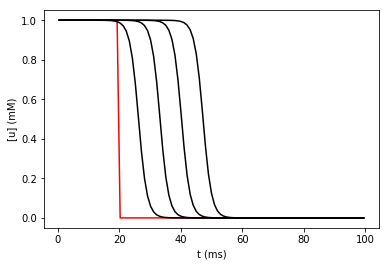

In [1]:
%matplotlib inline

from neuron import h, rxd
import numpy
from matplotlib import pyplot

# needed for standard run system
h.load_file('stdrun.hoc')

dend = h.Section(name='dend')
dend.nseg = 101

# initial conditions
def my_initial(node):
    return 1 if node.x < 0.2 else 0

# WHERE the dynamics will take place
where = rxd.Region([dend])

# WHO the actors are
u = rxd.Species(where, d=1, initial=my_initial)

# HOW they act
bistable_reaction = rxd.Rate(u, -u * (1 - u) * (0.3 - u))

# initial conditions
h.finitialize(-65)

def plot_it(color='k'):
    y = u.nodes.concentration
    x = u.nodes.x

    # convert x from normalized position to microns
    x = dend.L * numpy.array(x)

    pyplot.plot(x, y, color)

plot_it('r')

for i in range(1, 5):
    h.continuerun(i * 25)
    plot_it()

pyplot.xlabel('t (ms)')
pyplot.ylabel('[u] (mM)')
pyplot.show()

We could, of course, have plotted with any of a number of other graphics libraries, including NEURON's built in <a href="/neuron/static/py_doc/visualization/graph.html">Graph</a>, <a href="//bokeh.pydata.org/en/latest/">Bokeh</a>, <a href="//plotnine.readthedocs.io/en/stable/">plotnine</a>, etc.

Besides the graph, this illustrates two other features not shown in the previous example: (1) we explicitly specify the list of <code>h.Section</code> objects for the <code>rxd.Region</code> and (2) we assign non-uniform initial conditions by passing a function that takes a node and returns a value to the <code>initial</code> keyword argument for the <code>rxd.Species</code>.